In [46]:
import numpy as np, pandas as pd, gc
from matplotlib import pyplot as plt
from corner import corner
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import cohen_kappa_score, f1_score, make_scorer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [47]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
variability_df = pd.read_csv('first_order_statistics.csv')
timescale_df = pd.read_csv('timescales.csv')
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(variability_df,left_on='designation',right_on='WISE_Designation')
joined = joined.merge(timescale_df,left_on='designation',right_on='WISE_Designation')
len(joined),joined.columns

(6484,
 Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
        'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
        'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
        'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
        'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
        'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName_x', 'MKType',
        'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
        'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1', 'CommonName_y', 'Class',
        'CoarseClass', 'IsBinary', 'WISE_Designation_x', 'N_obs', 'W1chi2',
        'W1chi2red', 'W1logchi2red', 'W1_MAD', 'W1_EWM', 'W1_logEWM', 'W2chi2',
        'W2chi2red', 'W2logchi2red', 'W2_MAD', 'W2_EWM', 'W2_logEWM',
        'W1-W2chi2', 'W1-W2chi2red', 'W1-W2logchi2red', 'W1-W2_MAD',
        'W1-W2_EWM', 'W1-W2_logEWM', 'WISE_Designation_y', 'N_visits',
        'W1_Nzeroe

In [56]:
foo = ['a','nan','inf','nan','bar']
for i,ent in enumerate(foo):
        if (ent == 'nan') or ('inf' in ent):
            foo[i] = ' - '
foo

['a', ' - ', ' - ', ' - ', 'bar']

In [62]:
header = r"""\centerwidetable
\begin{rotatetable*}
\begin{deluxetable*}{lccccchrr}
\tablefontsize{\scriptsize}
\tablecaption{Feature values and assigned labels for all stars in our sample. Missing numbers are indicated with ``-''. \label{tab:feature_values}}
\tablehead{\colhead{Common Name} & \colhead{$M_G$ [mag]} & \colhead{$G-J$ [mag]} & \colhead{$W1-W2$ [mag]} & \colhead{$\log\chi^2_{red,W1}$} & \colhead{$\log\langle \Delta t \rangle_{W1}$ [d]} & \colhead{Label} & \colhead{Coarse Label}} 
\startdata
"""
j=0
for i,row in joined.sort_values('ra').iterrows():
    if j == 10:
        break
    else:
        j+=1
    name = row['CommonName_x'].lstrip('V*').replace('[','{[').replace(']',']}').replace('Cl*','')
    if name[0:2] == 'SV':
        name = name.lstrip('SV*')
    if name[:4] == 'WISE':
        name = name[:4] + ' ' + name[4:]
    
    mg = f"{row['M_G']:.8f}"
    gj = f"{row['G-J']:.4f}"
    w1w2 = f"{row['W1-W2']:.4f}"
    
    chi1 = f"{row['W1logchi2red']:.3f}"
    mdt1 = f"{row['W1_log_meanDt']:.3f}" 
    
    
    c = row['Class']
    
    cc = row['CoarseClass']
    
    
    entry = list(map(str,[name,mg,gj,w1w2,chi1,mdt1,c,cc]))
    
    for i,ent in enumerate(entry):
        if (ent == 'nan') or ('inf' in ent):
            entry[i] = ' - '
        
    
    sep = ' & '
    
    header += sep.join(entry)
    header += ' \\\\ \n'
header.rstrip()
header.rstrip('\\')
header.rstrip()
header += r"""\enddata
\tablecomments{To illustrate the content of the table, we only show the first ten rows, and a subset of the features. A complete machine-readable version will be made available online via Vizier.}
\end{deluxetable*}
\end{rotatetable*}

"""
with open("feature_table.txt", "w") as text_file:
        text_file.write(header)

In [3]:
training_indices = np.array([c not in np.array(['Misc. Variable','Unknown/Candidate']) 
 for c in joined['Class'].values]) & np.array([i == 0 for i in joined['IsBinary'].values]) & (joined['J-H'] < 2)
training_data = joined[training_indices].reset_index()

In [4]:
X = training_data[['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1','W1logchi2red','W1_logEWM','W1_Nzeroes',
                   'W1_log_meanDt', 'W1_log_stdDt','W2logchi2red','W2_logEWM','W2_Nzeroes', 'W2_log_meanDt',
                   'W2_log_stdDt','W1-W2logchi2red','W1-W2_logEWM','W1-W2_Nzeroes','W1-W2_log_meanDt','W1-W2_log_stdDt']]
#replace infs with nans
X.replace([np.inf, -np.inf], np.nan,inplace=True)

y = training_data['Class'].values
y_c = training_data['CoarseClass'].values

#split into train and test; we don't need the test for this notebook, so we're going to throw it out. First do the coarse classes
_,_,y_c,_ = train_test_split(X, y_c,
                            stratify=y, 
                            test_size=0.3,
                            random_state=0)

#then the refined, replacing variables
X, _X, y, _y = train_test_split(X, y,
                                stratify=y, 
                                test_size=0.3,
                                random_state=0)


#scale, and then use an IterativeImputer to replace NaNs with interpolated values
scaler=StandardScaler()
imputer = IterativeImputer(max_iter=100, random_state=0)
X_scale = imputer.fit_transform(scaler.fit_transform(X))

#should print zero if all successfully replaced
print(np.sum(np.isnan(X_scale)))

/Users/carina/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


0


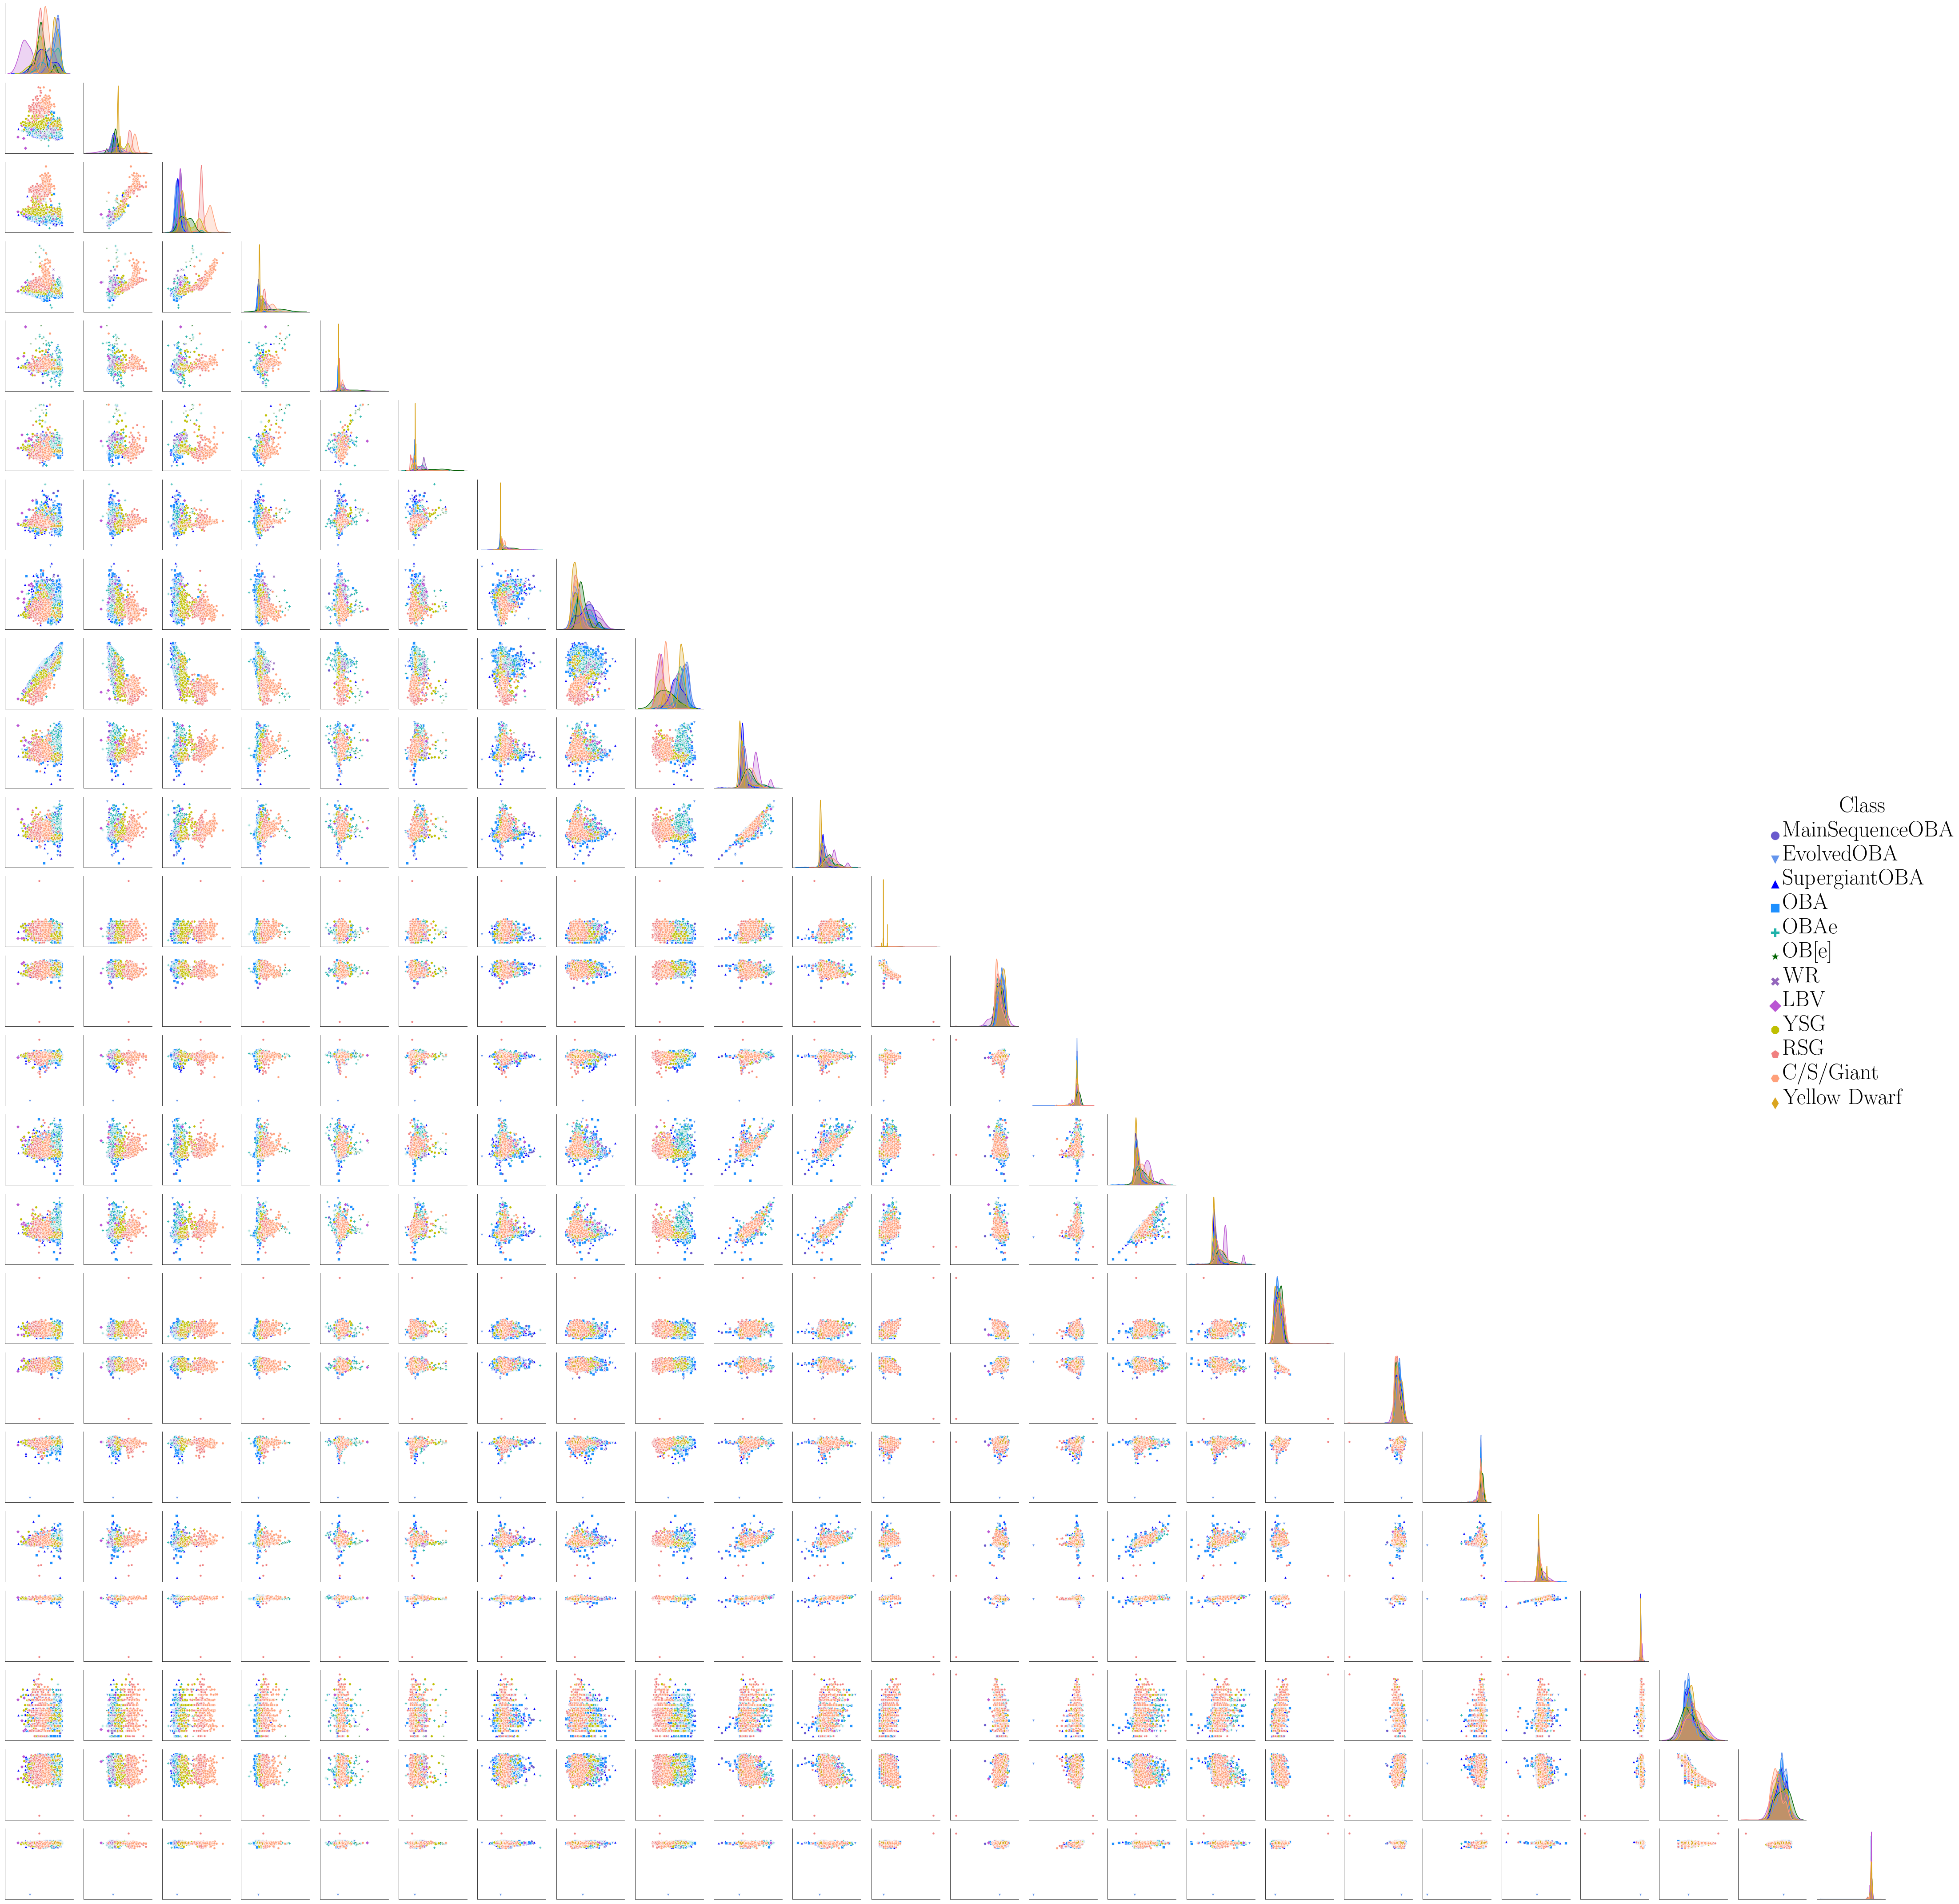

In [5]:
#Let's make a scatter plot of our features plotted against each other
variables = ['$M_G$','$G-J$','$J-H$','$H-K$','$K-W1$','$W1-W2$','$W2-W3$','$W3-W4$','$M_{W1}$',r'$\log\chi^2_{red,W1}$',
             r'$\log$ EWM$_{W1}$',r'$\nu_{0,W1}$',r'$\log\langle \Delta t \rangle_{W1}$',
             r'$\log\sigma_{\Delta t,W1}$',r'$\log\chi^2_{red,W2}$',r'$\log$ EWM$_{W2}$',r'$\nu_{0,W2}$',
             r'$\log\langle \Delta t \rangle_{W2}$',r'$\log\sigma_{\Delta t,W2}$',r'$\log\chi^2_{red,W1-W1}$',
             r'$\log$ EWM$_{W1-W2}$',r'$\nu_{0,W1-W2}$',r'$\log\langle \Delta t \rangle_{W1-W2}$',
             r'$\log\sigma_{\Delta t,W1-W2}$','Class']

classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBA','OBAe','OB[e]','WR','LBV','YSG',
                   'RSG','C/S/Giant','Yellow Dwarf']

m_dict = {'MainSequenceOBA':'o','EvolvedOBA':'v','SupergiantOBA':'^','OBA':'s',
          'OBAe':'P','OB[e]':'*','WR':'X','LBV':'D','YSG':'8','RSG':'p','C/S/Giant':'H','Yellow Dwarf':'d'}
c_dict = {'MainSequenceOBA':'slateblue','EvolvedOBA':'cornflowerblue','SupergiantOBA':'b',
          'OBA':'dodgerblue','OBAe':'lightseagreen','OB[e]':'darkgreen','WR':'C4',
          'LBV':'mediumorchid','YSG':'y','RSG':'lightcoral','C/S/Giant':'lightsalmon','Yellow Dwarf':'goldenrod'}


import seaborn as sns
all_df = pd.DataFrame(data=X_scale)
all_df['Class'] = y
g = sns.pairplot(all_df, hue="Class",hue_order=classes,palette=c_dict,markers=list(m_dict.values()),diag_kind='kde',
                plot_kws={'rasterized':True})
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g.set(xlabel='',ylabel='',xticks=[],yticks=[])
plt.setp(g._legend.get_texts(), fontsize=50)
plt.setp(g._legend.get_title(), fontsize=50)
for i in range(len(classes)):
    g._legend.legendHandles[i]._sizes=[400]
g.savefig('../plots/feature_pairplot.pdf')

In [5]:
rf_params = {'max_depth': [int(x) for x in np.linspace(10, 110, 11)]+[None],'n_estimators':np.arange(10,160,10),
         'max_features': ['sqrt','log2',None]}
svm_params = [{"kernel": ["rbf"], "gamma":np.array([0.01,0.1,1,10,1.0/X_scale.shape[1]]), "C":[0.01,0.1,1,10,100]}, 
              #{"kernel": ["sigmoid"], "coef0": np.linspace(0,5,11), "gamma":np.array([0.01,0.1,1,10,1.0/X_scale.shape[1]]), 
               #"C":[0.01,0.1,1,10,100]},
              {"kernel": ["linear"],"C":[0.01,0.1,1,10,100]}]
gp_params = {'kernel':['linear','rbf','sigmoid',None]}

rf = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')
gp = GaussianProcessClassifier(n_jobs=-1)

#scorer = make_scorer(cohen_kappa_score)
#scorer = make_scorer(f1_weighted)
scorer = 'balanced_accuracy'

scores = []
best_estimators = []
from tqdm.notebook import tqdm
for clf,params in tqdm(zip([rf,svc,gp],[rf_params,svm_params,gp_params]),total=3):
    grid = GridSearchCV(clf, params, cv=5, n_jobs=14, verbose=10, error_score=-1e10,scoring=scorer)
    grid.fit(X_scale,y)
    best_estimators.append(grid.best_estimator_)
    scores.append(grid.best_score_)
    gc.collect()

    
#do the strafication
hardvoter = VotingClassifier(estimators=[('rf', best_estimators[0]), ('svm', best_estimators[1]), ('gp', best_estimators[2])],
                         voting='hard')
hardvoter_scores = cross_val_score(hardvoter, X_scale, y, n_jobs=2, cv=5, scoring=scorer, verbose=2, error_score=-1e10)
scores.append(hardvoter_scores.mean())
gc.collect()

#Now for a soft voting strategy
best_estimators[1].probability=True #for the soft voting, we need class probabilities
softvoter = VotingClassifier(estimators=[('rf', best_estimators[0]), ('svm', best_estimators[1]), ('gp', best_estimators[2])],
                         voting='soft')
softvoter_scores = cross_val_score(softvoter, X_scale, y, n_jobs=2, cv=5, scoring=scorer, verbose=2, error_score=-1e10)
scores.append(softvoter_scores.mean())
gc.collect()
#Now for a soft voting strategy with weights
weightedvoter = VotingClassifier(estimators=[('rf', best_estimators[0]), ('svm', best_estimators[1]), ('gp', best_estimators[2])],
                         voting='soft',weights=scores[:3])
weightedvoter_scores = cross_val_score(weightedvoter, X_scale, y, n_jobs=2, cv=5, scoring=scorer, verbose=2, error_score=-1e10)
scores.append(weightedvoter_scores.mean())
gc.collect()

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    1.6s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    1.9s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:    2.3s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:    2.8s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:    3.7s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:    4.4s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:    4.8s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:    5.3s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:    6.1s
[Parallel(n_jobs=14)]: Done 134 tasks      | elapsed:    7.2s
[Parallel(n_jobs=14)]: Done 153 tasks      | elapsed:    8.4s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:   10.6s
[Parallel(n_jobs=14)]: Done 193 tasks      | elapsed:   15.6s
[Parallel(n_jobs=14)]: Done 214 tasks      | elapsed:  

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    0.9s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    1.6s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:    2.1s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:    2.6s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:    3.0s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:    3.7s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:    4.1s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:    5.0s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:    6.0s
[Parallel(n_jobs=14)]: Done 139 out of 150 | elapsed:    6.5s remaining:    0.5s
[Parallel(n_jobs=14)]: Done 150 out of 150 | elapsed:   14.4s finished
/Users/carina/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Batch computation too fast (0.1317s.) Setting batch_size=2.
[Parallel(n_jobs=14)]: Done   2 out of  20 | elapsed:    0.1s remaining:    1.2s
[Parallel(n_jobs=14)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=14)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=14)]: Done  11 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=14)]: Done  14 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=14)]: Done  17 out of  20 | elapsed:   53.3s remaining:    9.4s
[Parallel(n_jobs=14)]: Done  20 out of  20 | elapsed:   54.1s remaining:    0.0s
[Parallel(n_jobs=14)]: Done  20 out of  20 | elapsed:   54.1s finished
/Users/carina/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 

96

In [6]:
scores

[0.47984538424358,
 0.5313991466300478,
 0.4008053669511598,
 0.4860107662097823,
 0.4007053159414794,
 0.40395859979455057]

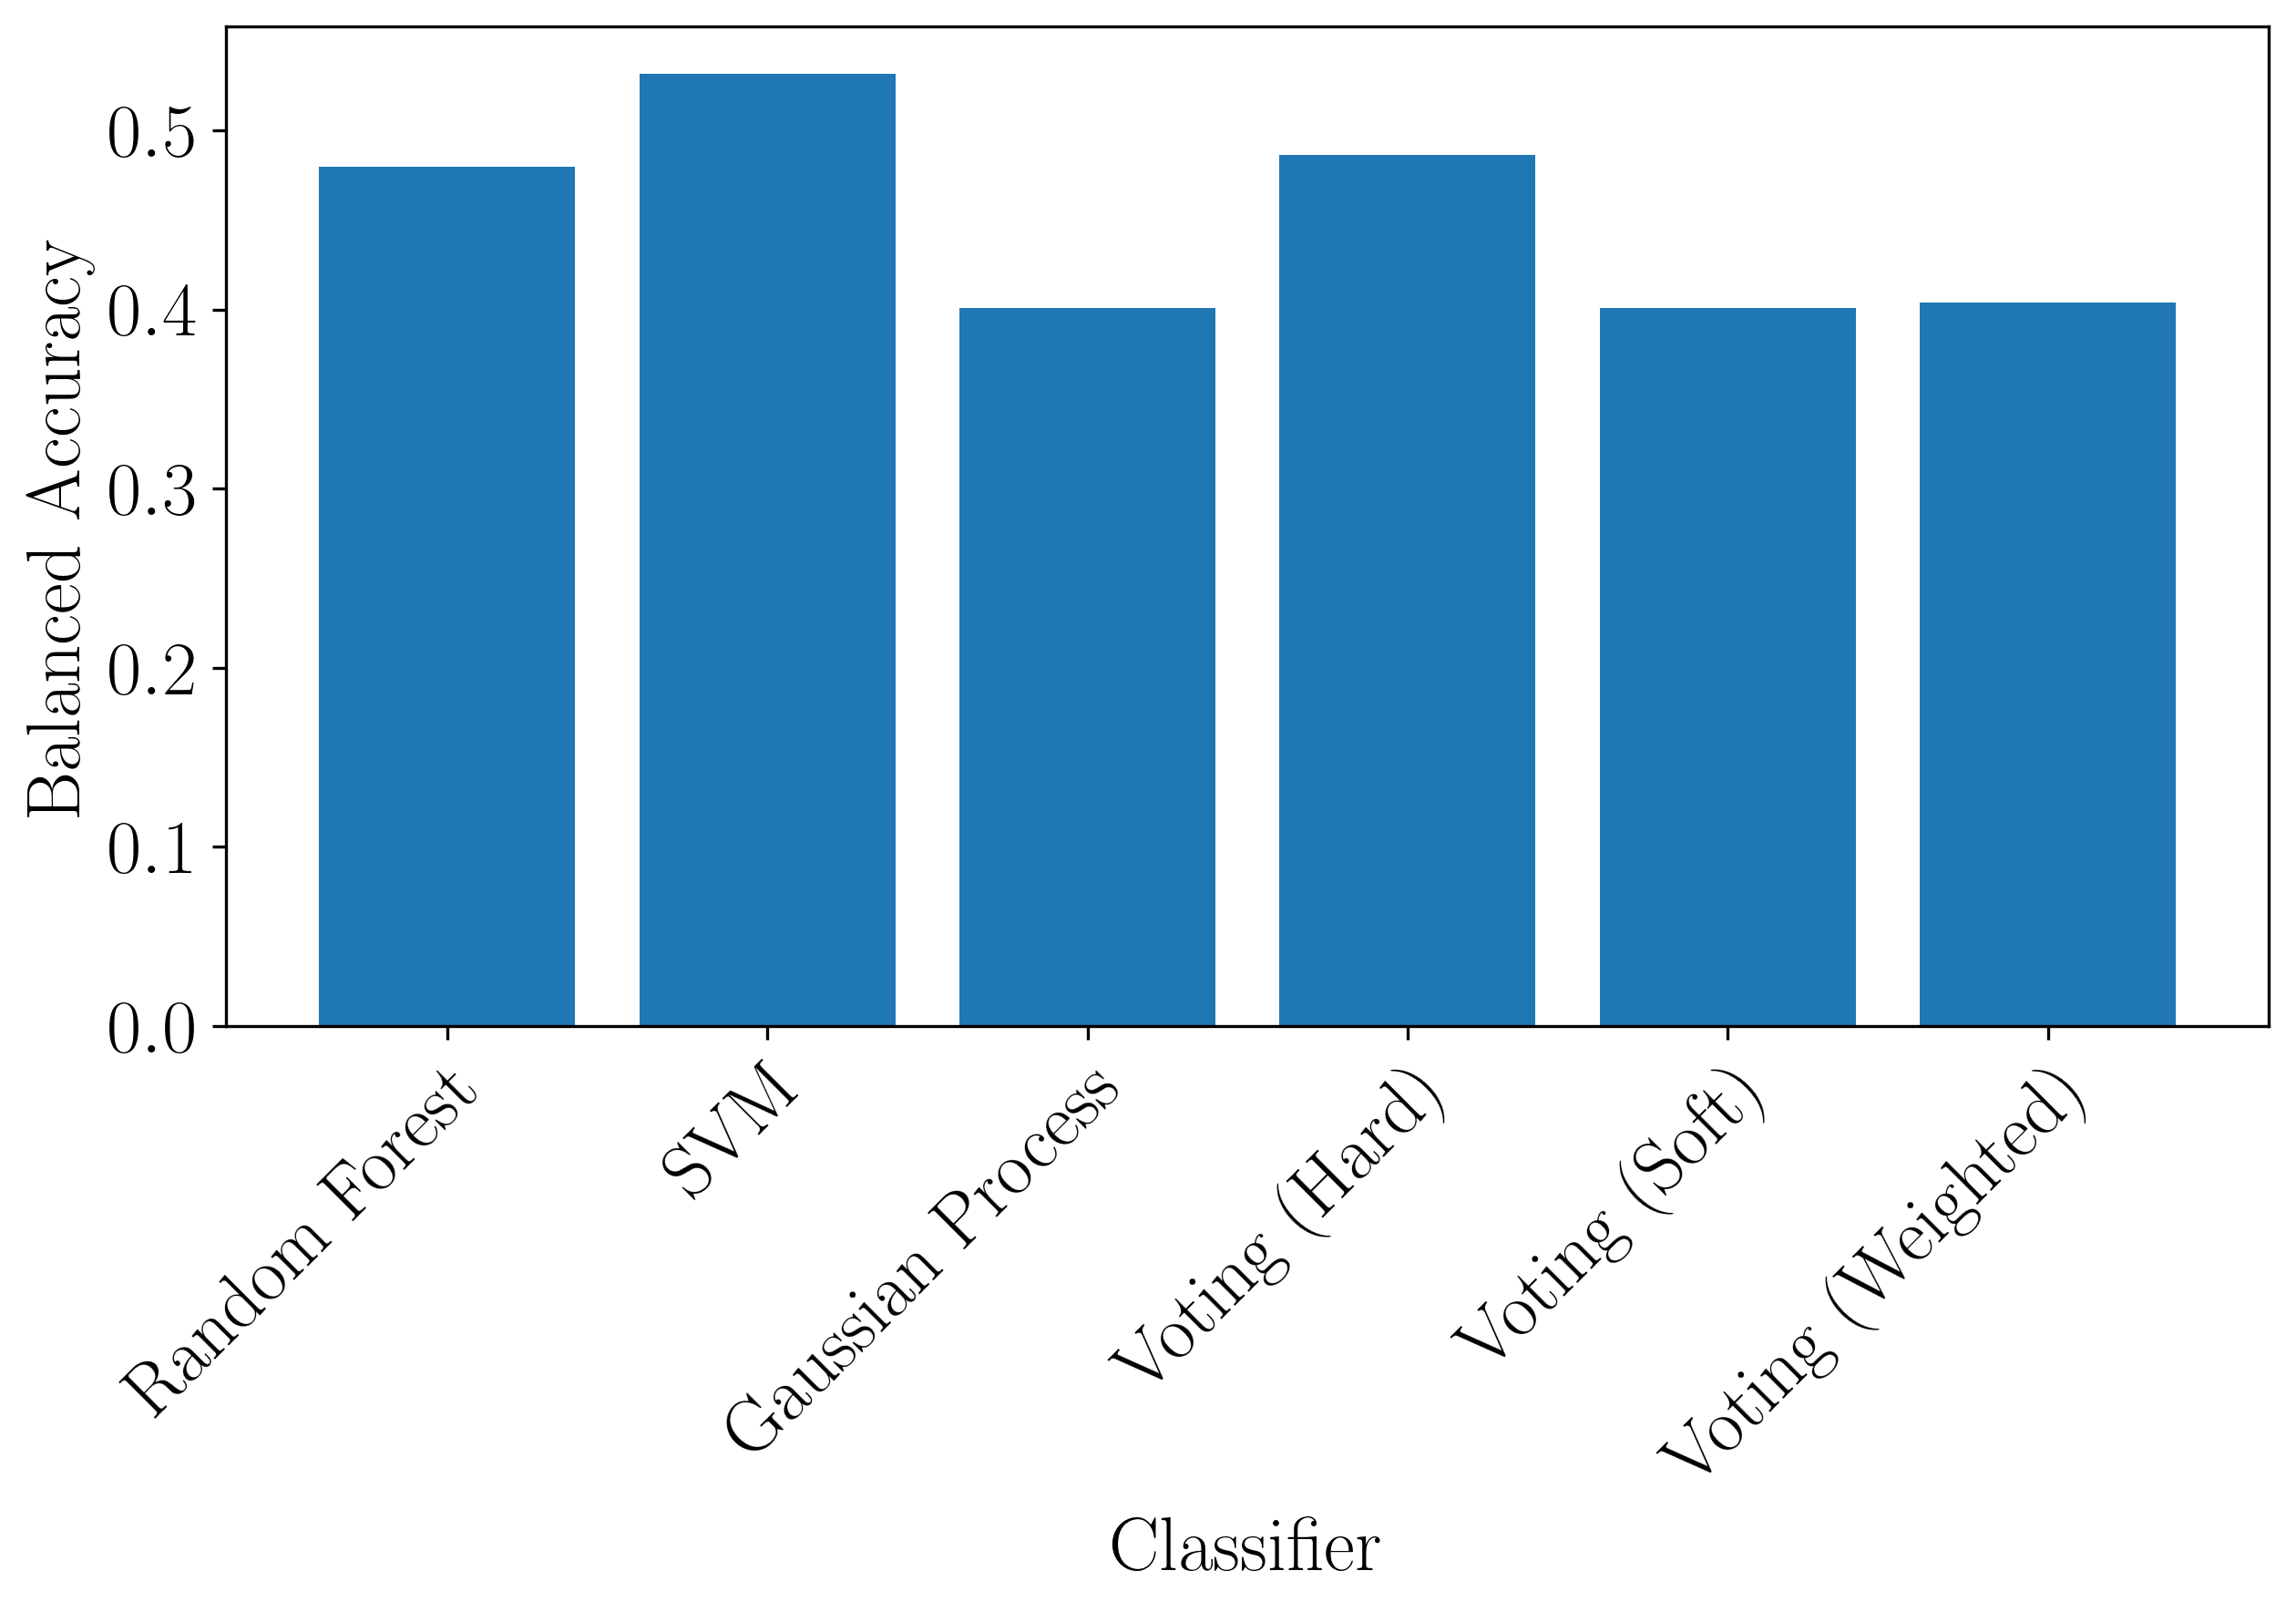

In [7]:
classifiers = ['Random Forest','SVM','Gaussian Process','Voting (Hard)','Voting (Soft)','Voting (Weighted)']

plt.figure(dpi=300,figsize=(8.5,6))
plt.bar(np.arange(6),scores)

plt.xticks(ticks=np.arange(6),labels=classifiers,rotation=45,ha="right",rotation_mode="anchor")
plt.xlabel('Classifier',fontsize=20)
plt.ylabel('Balanced Accuracy',fontsize=20)
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.tight_layout()
plt.savefig('../plots/classifier_performance.pdf')

# How does this perform on the coarse labels?

In [8]:
rf_params = {'max_depth': [int(x) for x in np.linspace(10, 110, 11)]+[None],'n_estimators':np.arange(10,160,10),
         'max_features': ['sqrt','log2',None]}
svm_params = [{"kernel": ["rbf"], "gamma":np.array([0.01,0.1,1,10,1.0/X_scale.shape[1]]), "C":[0.01,0.1,1,10,100]}, 
              #{"kernel": ["sigmoid"], "coef0": np.linspace(0,5,11), "gamma":np.array([0.01,0.1,1,10,1.0/X_scale.shape[1]]), 
               #"C":[0.01,0.1,1,10,100]},
              {"kernel": ["linear"],"C":[0.01,0.1,1,10,100]}]
gp_params = {'kernel':['linear','rbf','sigmoid',None]}

rf = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')
gp = GaussianProcessClassifier(n_jobs=-1)

scorer = make_scorer(cohen_kappa_score)
scorer = 'balanced_accuracy'

scores_c = []
best_estimators_c = []
from tqdm.notebook import tqdm
for clf,params in tqdm(zip([rf,svc,gp],[rf_params,svm_params,gp_params]),total=3):
    grid = GridSearchCV(clf, params, cv=5, n_jobs=14, verbose=10, error_score=-1e10,scoring=scorer)
    grid.fit(X_scale,y_c)
    best_estimators_c.append(grid.best_estimator_)
    scores_c.append(grid.best_score_)

    
#do the strafication
hardvoter = VotingClassifier(estimators=[('rf', best_estimators_c[0]), ('svm', best_estimators_c[1]), ('gp', best_estimators_c[2])],
                         voting='hard')
hardvoter_scores = cross_val_score(hardvoter, X_scale, y_c, cv=5, scoring=scorer, n_jobs=-1, verbose=10, error_score=-1e10)
scores_c.append(hardvoter_scores.mean())


#Now for a soft voting strategy
best_estimators_c[1].probability=True #for the soft voting, we need class probabilities
softvoter = VotingClassifier(estimators=[('rf', best_estimators_c[0]), ('svm', best_estimators_c[1]), ('gp', best_estimators_c[2])],
                         voting='soft')
softvoter_scores = cross_val_score(softvoter, X_scale, y_c, cv=5, scoring=scorer, n_jobs=-1, verbose=10, error_score=-1e10)
scores_c.append(softvoter_scores.mean())

#Now for a soft voting strategy with weights
weightedvoter = VotingClassifier(estimators=[('rf', best_estimators_c[0]), ('svm', best_estimators_c[1]), ('gp', best_estimators_c[2])],
                         voting='soft',weights=scores_c[:3])
weightedvoter_scores = cross_val_score(weightedvoter, X_scale, y_c, cv=5, scoring=scorer, n_jobs=-1, verbose=10, error_score=-1e10)
scores_c.append(weightedvoter_scores.mean())

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Batch computation too fast (0.0981s.) Setting batch_size=4.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    1.4s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    1.6s
[Parallel(n_jobs=14)]: Done  48 tasks      | elapsed:    3.4s
[Parallel(n_jobs=14)]: Batch computation too slow (2.1727s.) Setting batch_size=2.
[Parallel(n_jobs=14)]: Done  92 tasks      | elapsed:    5.1s
[Parallel(n_jobs=14)]: Batch computation too slow (4.2408s.) Setting batch_size=1.
[Parallel(n_jobs=14)]: Done 142 tasks      | elapsed:    8.0s
[Parallel(n_jobs=14)]: Done 180 tasks      | elapsed:   12.3s
[Parallel(n_jobs=14)]: Done 206 tasks      | elapsed:   18.1s
[Parallel(n_jobs=14)]: Done 223 tasks      | elapsed:   20.3s
[Parallel(n_jobs=14)]: Done 240 tasks      | elapsed:   21.5s
[Parallel(n_jobs=14)]: Done 257 tasks      | elapsed: 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    0.6s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    1.1s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:    1.4s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:    1.7s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:    1.9s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:    2.4s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:    2.6s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:    3.1s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:    3.7s
[Parallel(n_jobs=14)]: Done 139 out of 150 | elapsed:    4.1s remaining:    0.3s
[Parallel(n_jobs=14)]: Done 150 out of 150 | elapsed:    9.1s finished
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=14)]: Batch computation too fast (0.1246s.) Setting batch_size=2.
[Parallel(n_jobs=14)]: Done   2 out of  20 | elapsed:    0.1s remaining:    1.1s
[Parallel(n_jobs=14)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=14)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=14)]: Done  11 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=14)]: Done  14 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=14)]: Done  17 out of  20 | elapsed:   16.7s remaining:    2.9s
[Parallel(n_jobs=14)]: Done  20 out of  20 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=14)]: Done  20 out of  20 | elapsed:   17.2s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.4s remaining:   24.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.4s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.9s remaining:   25.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.1s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.7s remaining:   26.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.7

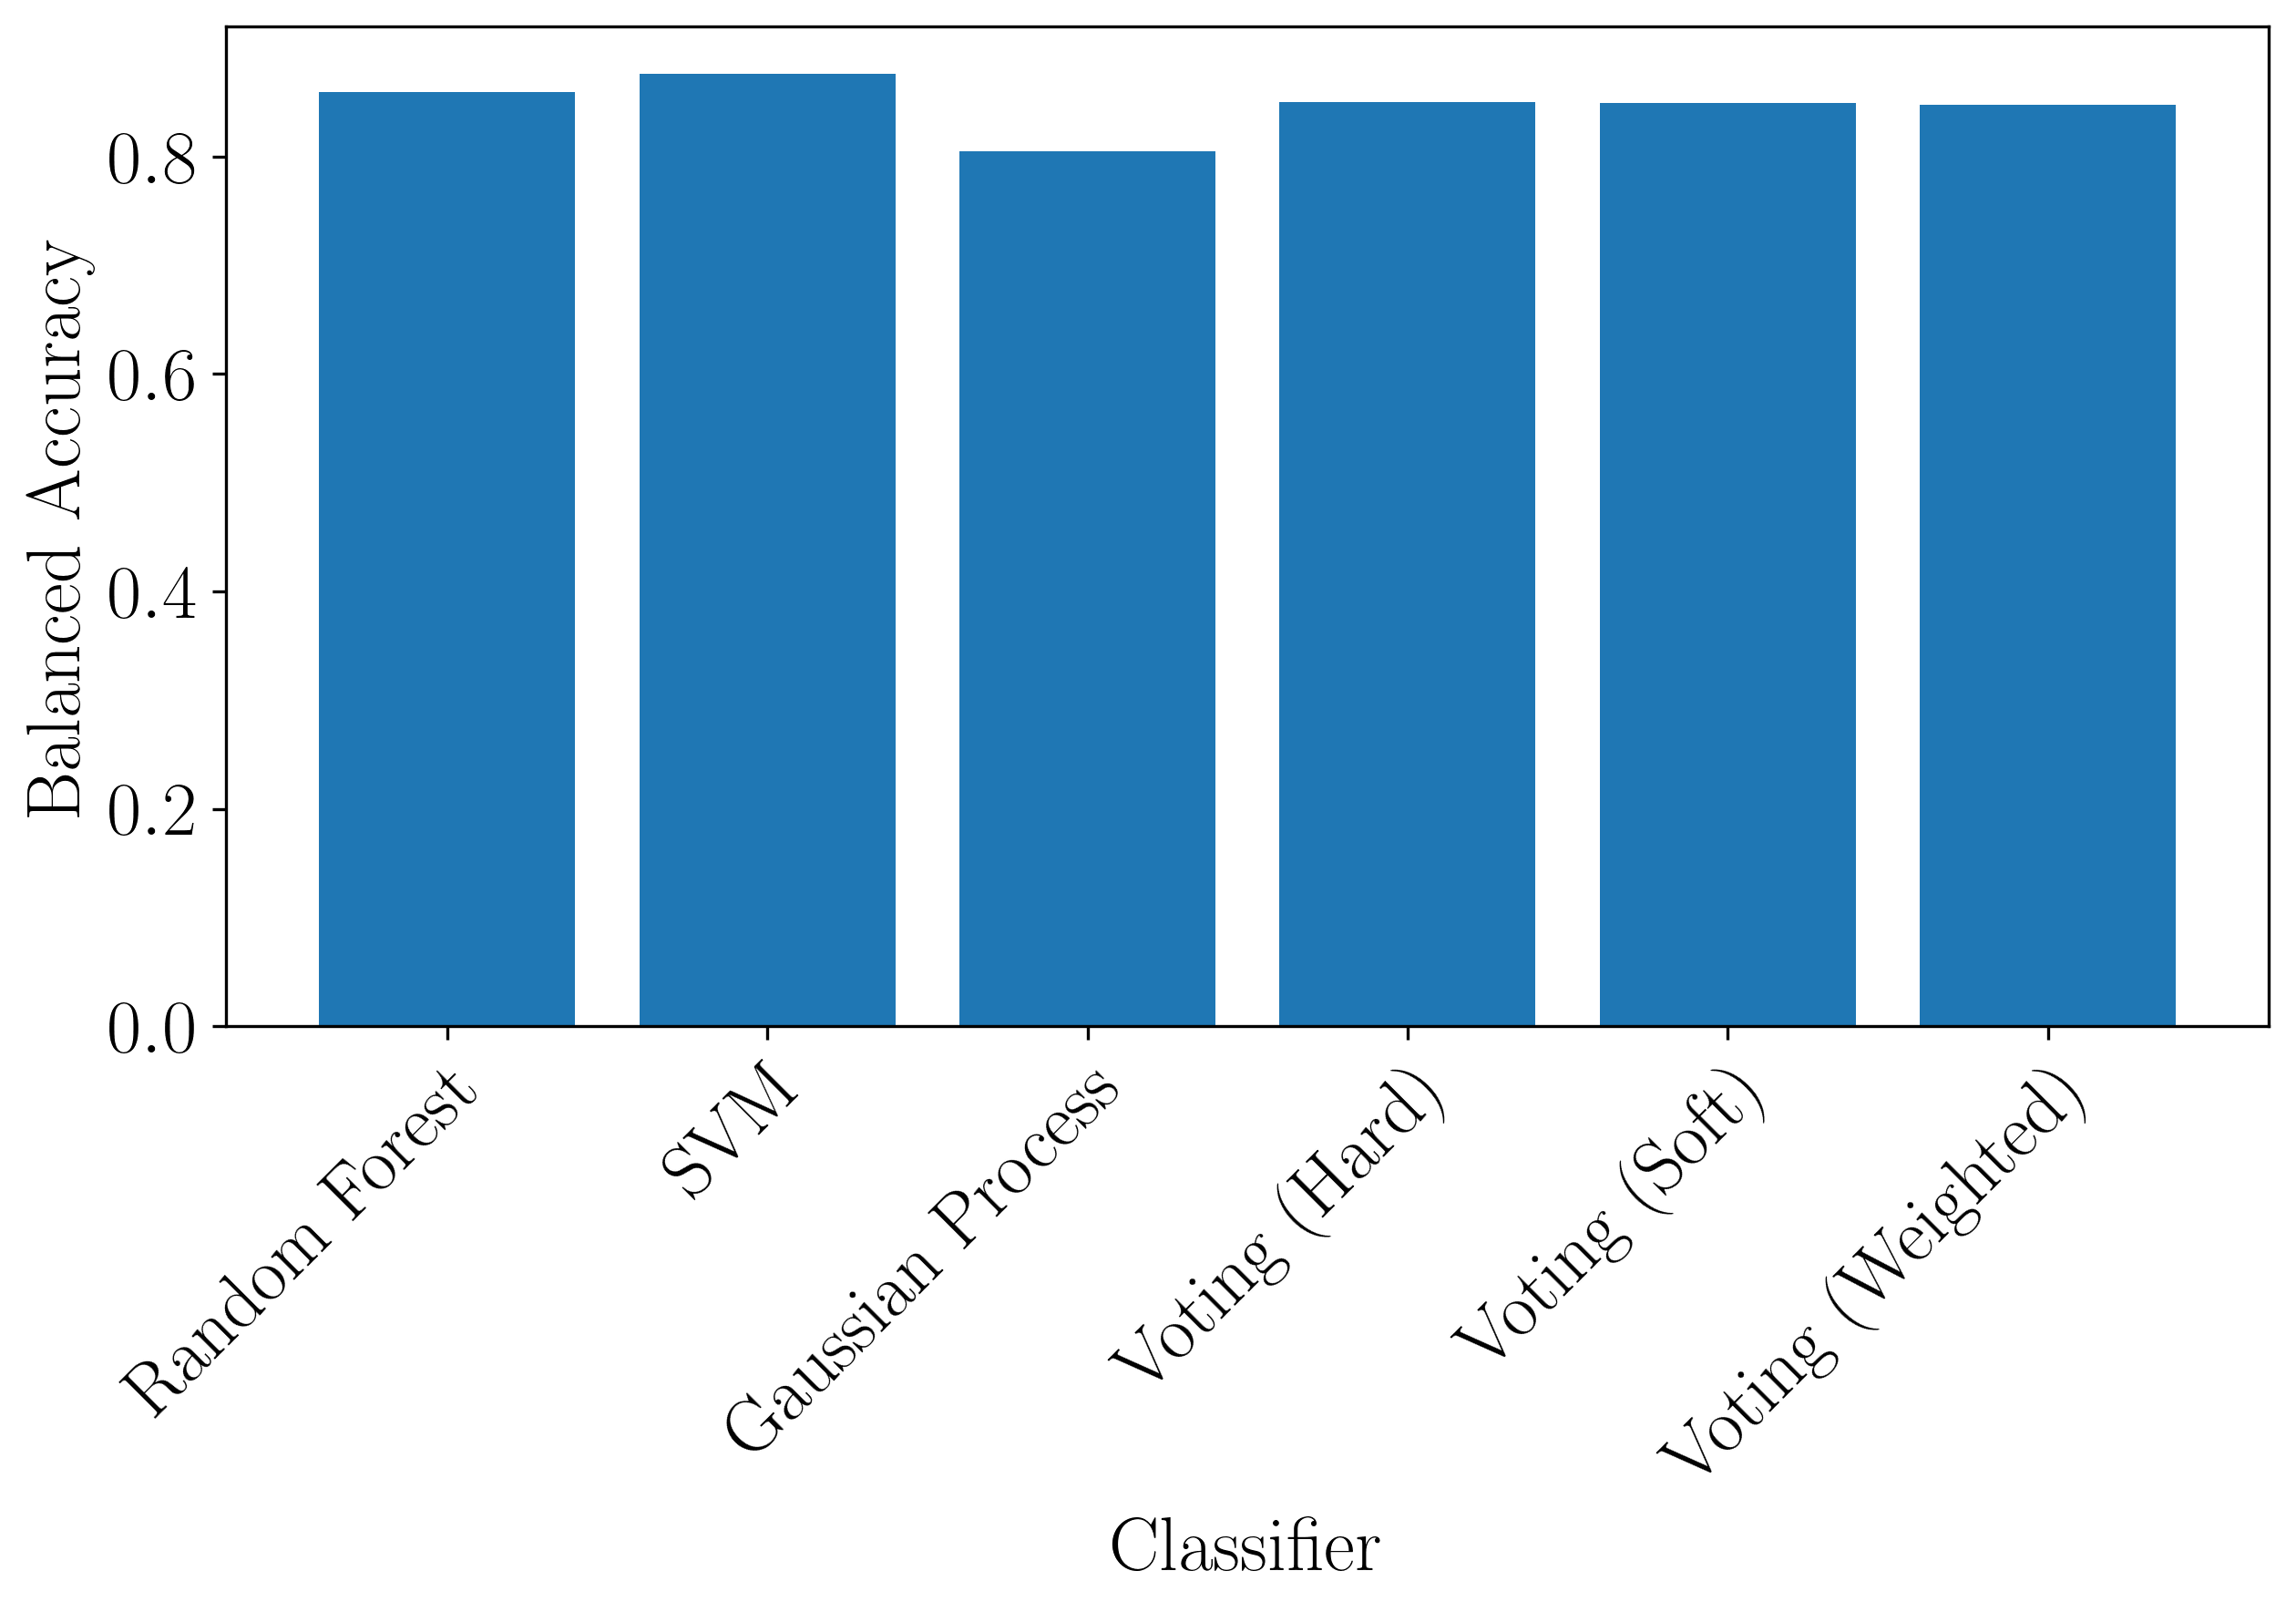

In [9]:
classifiers = ['Random Forest','SVM','Gaussian Process','Voting (Hard)','Voting (Soft)','Voting (Weighted)']

plt.figure(dpi=300,figsize=(8.5,6))
plt.bar(np.arange(6),scores_c)

plt.xticks(ticks=np.arange(6),labels=classifiers,rotation=45,ha="right",rotation_mode="anchor")
plt.xlabel('Classifier',fontsize=20)
plt.ylabel('Balanced Accuracy',fontsize=20)
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.tight_layout()
plt.savefig('../plots/classifier_performance_coarse.pdf')

In [10]:
scores_c

[0.8594691981378569,
 0.8758188530020202,
 0.8049751612505505,
 0.8502176254944741,
 0.8492979852323194,
 0.8473891266105792]

In [16]:
softvoter.fit(X_scale,y)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=10,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=20,
                                                     n_jobs=None,
       

In [35]:
tr = softvoter.transform(X_scale)

Text(0, 0.5, 'Prob')

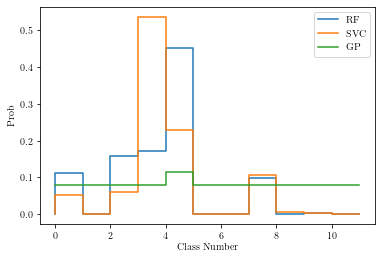

In [45]:
for i,l in zip(tr[10].reshape(3,12),['RF','SVC','GP']):
    plt.step(np.arange(12),i,label=l)
plt.legend()
plt.xlabel('Class Number')
plt.ylabel('Prob')